In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer,Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
bit_test = pd.read_csv('bit_c_1m.csv')
bit_test['Open Time']=pd.to_datetime(bit_test['Open Time'])
bit_test.set_index('Open Time', inplace=True)
bit_test=bit_test[1:]
bit_test=pd.DataFrame(bit_test['Close'])
bit_test

,Close
Open Time,
2021-01-01 00:01:00,29009.91
2021-01-01 00:02:00,28989.30
2021-01-01 00:03:00,28982.69
2021-01-01 00:04:00,28975.65
2021-01-01 00:05:00,28937.11
...,...
2021-05-12 05:35:00,57485.07
2021-05-12 05:36:00,57481.49
2021-05-12 05:37:00,57470.00


In [4]:
def emd_calculate(data,emdtype=EMD, plots=True):
    EMD_C=emdtype()#EMD,EEMD,CEEMDAN
    imfs = EMD_C(data.values.reshape(len(data)))
        
    if plots:
        series_index = data.index
        fig = plt.figure(figsize=(16,2*len(imfs)))
        plt.subplot(1+len(imfs), 1, 1 )
        plt.plot(series_index, data, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')

        # Plot IMFs
        for i in range(len(imfs)):
            plt.subplot(1 +len(imfs),1,2 + i)
            plt.plot(series_index, imfs[i, :], color='#F27F19')
            plt.ylabel('IMF'+str(i))
        plt.show()
    imfs=pd.DataFrame(imfs,columns=data.index)
    return imfs

In [5]:
def create_noisy(data,percentage=0.5,size=10):
    data_noisy = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[i-window:i,0])], axis=1)
    return data_noisy.T

In [6]:
def create_pure(data,percentage=0.5,size=10,emdtype=EMD,emdsum=1):
    data_pure = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        temp=emd_calculate(data[i-window:i],plots=False,emdtype=emdtype)
        temp_1= reconstruction(temp)
        data_pure= pd.concat([data_pure,pd.Series(temp_1.values[emdsum,:])], axis=1)
    return data_pure.T

In [7]:
def reconstruction(data_emd):
    reconstruction = pd.DataFrame()
    for i in range(len(data_emd)):
        reconstruction['sum'+str(i)]=data_emd.iloc[i:,:].sum(axis=0)
    return reconstruction.T

In [10]:
GSPC_pure=create_noisy(bit_test,size=2000)

GSPC_noisy=create_noisy(bit_test,size=2000)

In [11]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(48, 94158)
(48, 94158)


In [12]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0,shuffle=False)

In [13]:
keras.backend.clear_session()

In [14]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu',kernel_constraint=max_norm(1), padding='same',input_shape=(None, 1)))
    model.add(Conv1D(32, kernel_size=3,activation='relu',kernel_constraint=max_norm(1),padding='same'))
    model.add(Conv1DTranspose(32, kernel_size=3, activation='relu',kernel_constraint=max_norm(1), padding='same'))
    model.add(Conv1DTranspose(128, kernel_size=3,activation='relu',kernel_constraint=max_norm(1),padding='same'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, None, 32)         3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, None, 128)        12416     
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 1)           385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-traina

In [15]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
2/2 [==============================] - 20s 4s/step - loss: 0.0663 - mae: 0.2244 - val_loss: 0.0358 - val_mae: 0.1535
Epoch 2/400
2/2 [==============================] - 18s 4s/step - loss: 0.0601 - mae: 0.2102 - val_loss: 0.0318 - val_mae: 0.1416
Epoch 3/400
2/2 [==============================] - 17s 4s/step - loss: 0.0542 - mae: 0.1956 - val_loss: 0.0290 - val_mae: 0.1316
Epoch 4/400
2/2 [==============================] - 18s 4s/step - loss: 0.0495 - mae: 0.1815 - val_loss: 0.0283 - val_mae: 0.1277
Epoch 5/400
2/2 [==============================] - 17s 4s/step - loss: 0.0464 - mae: 0.1710 - val_loss: 0.0301 - val_mae: 0.1336
Epoch 6/400
2/2 [==============================] - 16s 4s/step - loss: 0.0457 - mae: 0.1676 - val_loss: 0.0298 - val_mae: 0.1344
Epoch 7/400
2/2 [==============================] - 17s 4s/step - loss: 0.0437 - mae: 0.1639 - val_loss: 0.0254 - val_mae: 0.1213
Epoch 8/400
2/2 [==============================] - 17s 5s/step - loss: 0.0399 - mae: 0.1569 - val

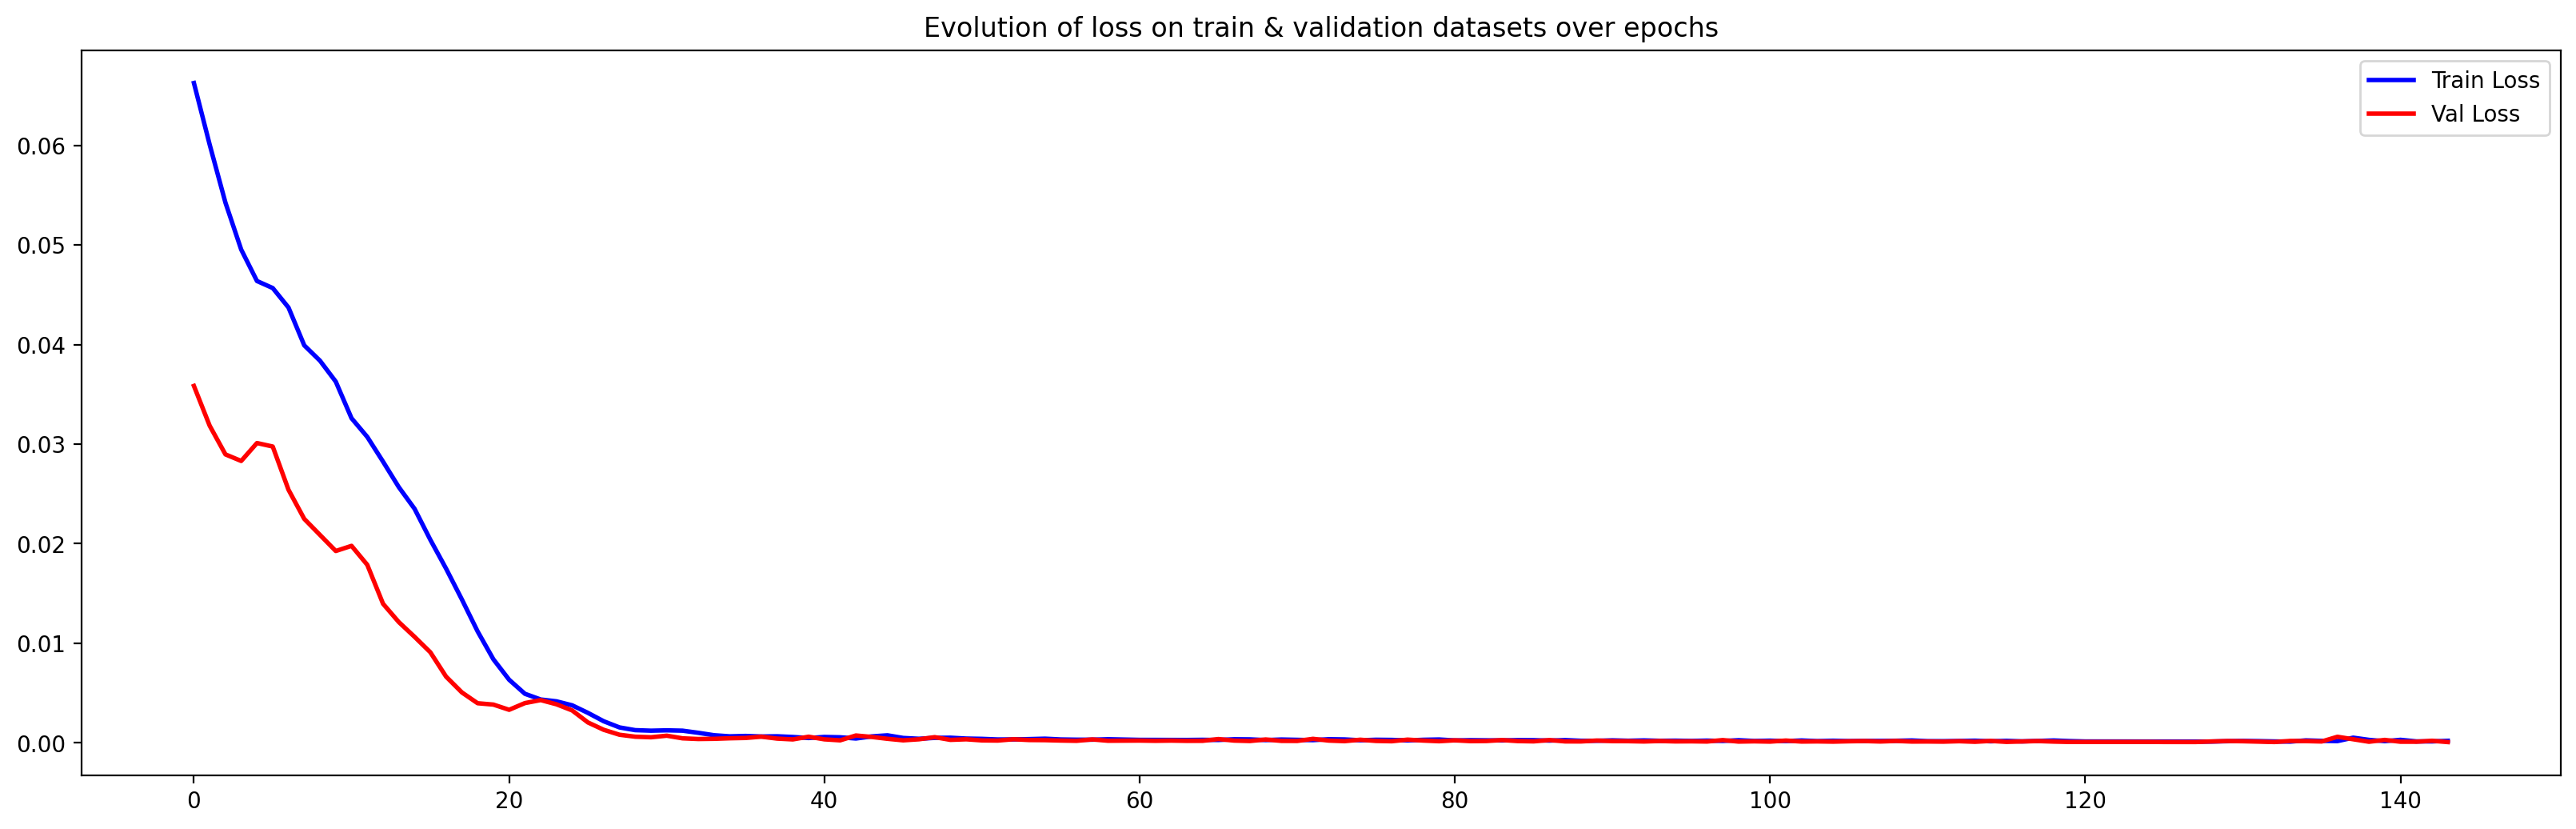

In [16]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure(figsize=(20,6),dpi=200)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

In [17]:
GSPC_test = bit_test#Choose the data
GSPC_test

,Close
Open Time,
2021-01-01 00:01:00,29009.91
2021-01-01 00:02:00,28989.30
2021-01-01 00:03:00,28982.69
2021-01-01 00:04:00,28975.65
2021-01-01 00:05:00,28937.11
...,...
2021-05-12 05:35:00,57485.07
2021-05-12 05:36:00,57481.49
2021-05-12 05:37:00,57470.00


1/1 [==============================] - 1s 1s/step


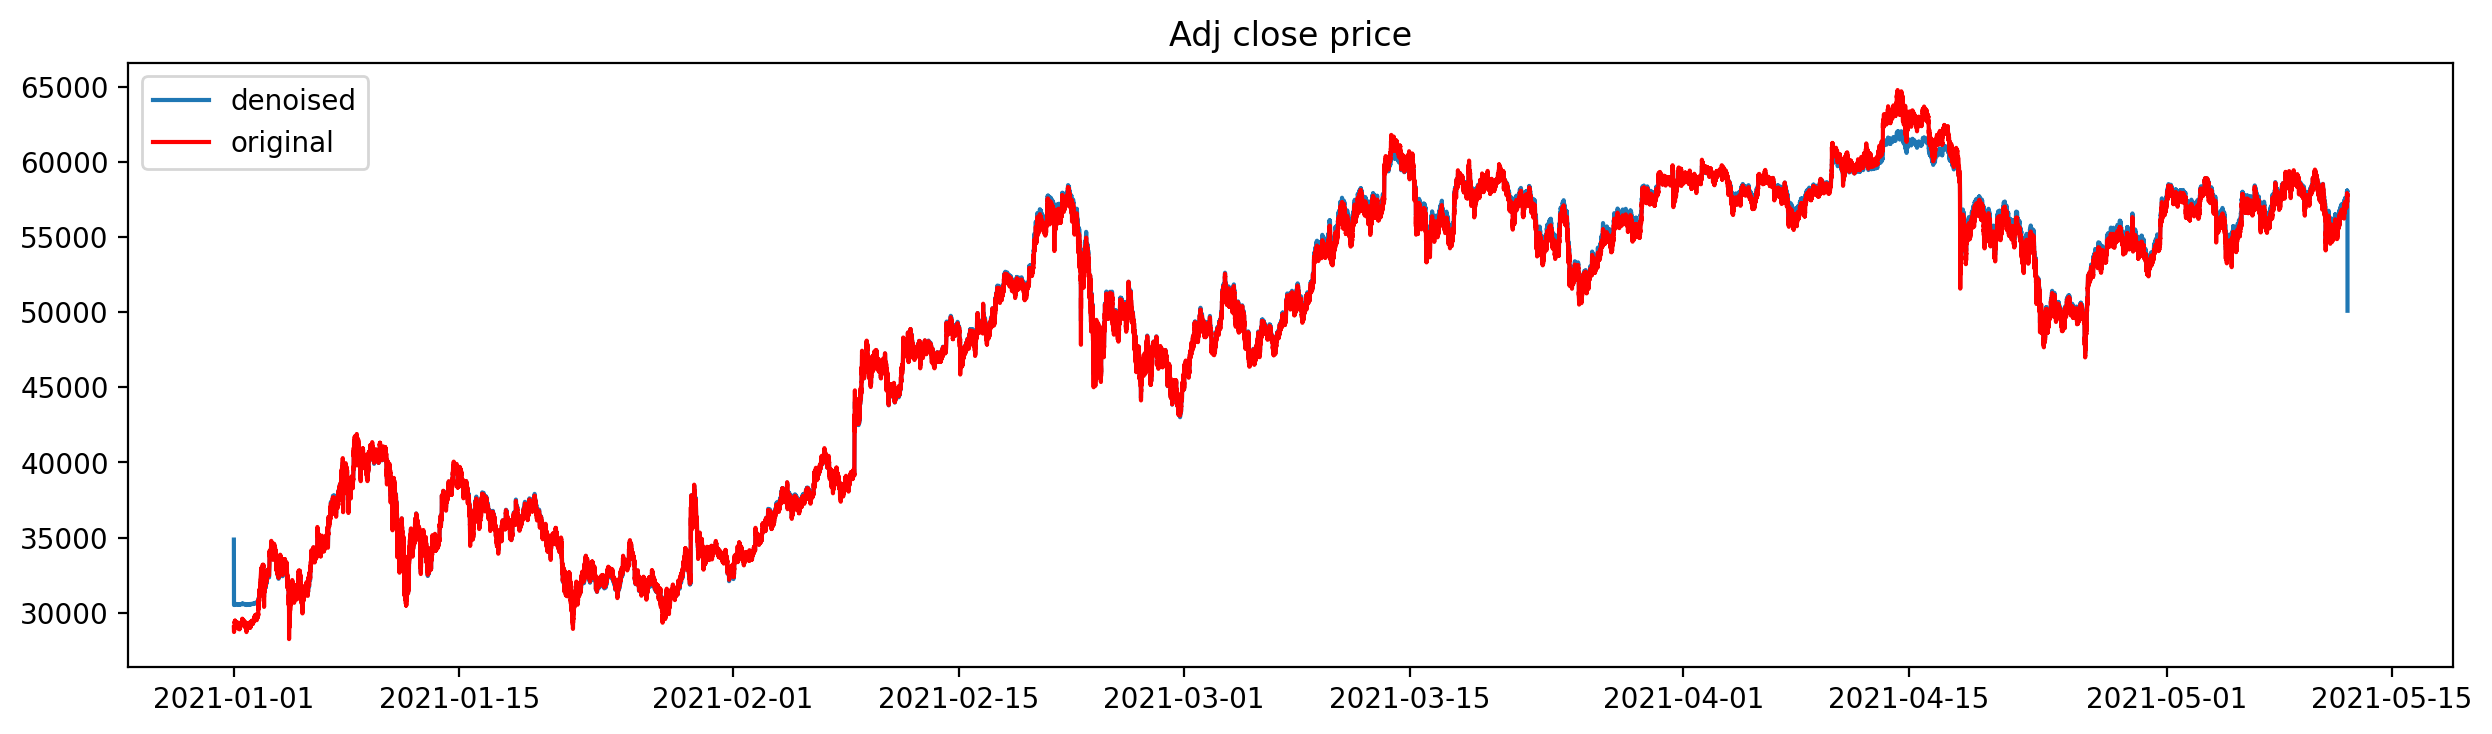

In [18]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
noise_mm_T=pd.DataFrame(noise_mm_T,columns=['Adj Close'],index=GSPC_test.index)
Y_test_mm_cnn=pd.DataFrame(Y_test_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('Adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

In [19]:
original=GSPC_test
recon=pure_mm_cnn

In [20]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [21]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

3835.2534561287857
2279.927071059725
26693579.459006283
6016359.7099310905
8645.815591918012
171177.06931402336
2181.826995237994
626055.4156486525
4894.919472232165
4338.698327173486
The last MSE: 4338.698327173486
The average MSE: 3353334.8094813796


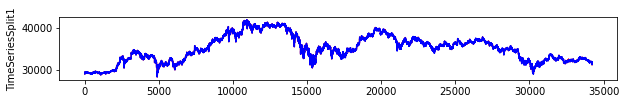

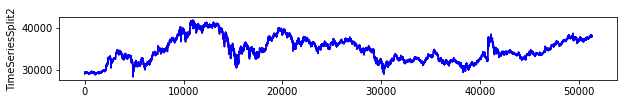

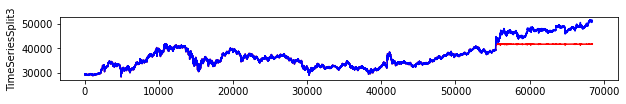

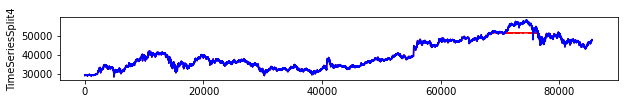

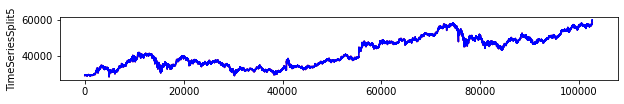

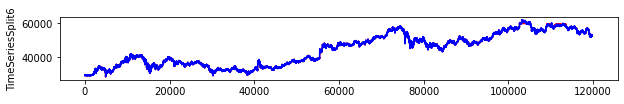

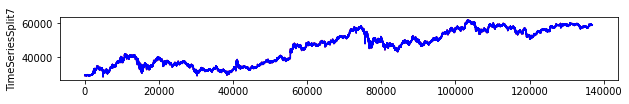

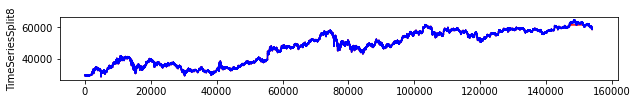

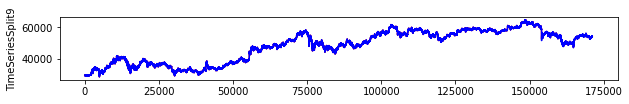

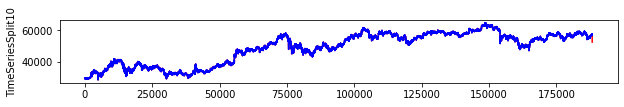

In [22]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    msetestav+=msetest
    print(msetest)
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [23]:
original=pd.DataFrame(original).rename(columns={'Close':'Adj Close'})
original

,Adj Close
Open Time,
2021-01-01 00:01:00,29009.91
2021-01-01 00:02:00,28989.30
2021-01-01 00:03:00,28982.69
2021-01-01 00:04:00,28975.65
2021-01-01 00:05:00,28937.11
...,...
2021-05-12 05:35:00,57485.07
2021-05-12 05:36:00,57481.49
2021-05-12 05:37:00,57470.00


6959.288549566705
4641.225435585642
28271068.21184866
6095684.625164483
10902.335757344075
198253.59791907933
3662.9754652226393
717363.6937461786
8267.96235254641
4237.80436168226
The last MSE: 4237.80436168226
The average MSE: 3532104.1720600342


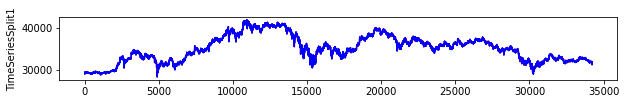

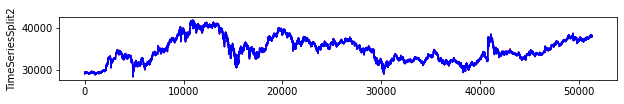

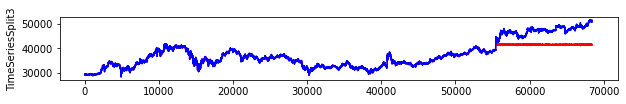

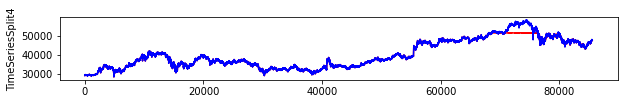

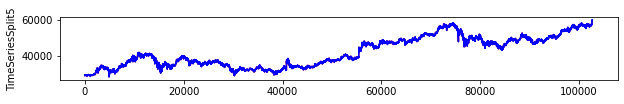

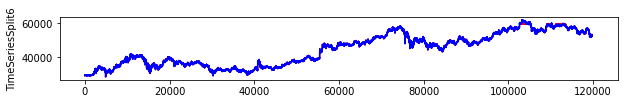

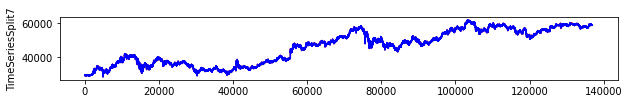

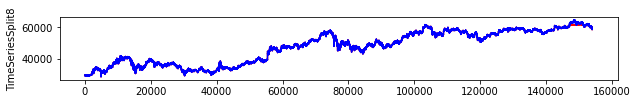

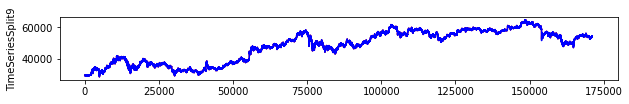

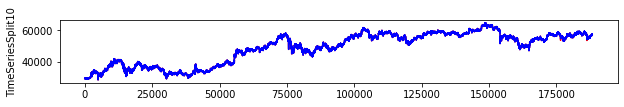

In [24]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    msetestav+=msetest
    print(msetest)
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

# EMDCNN

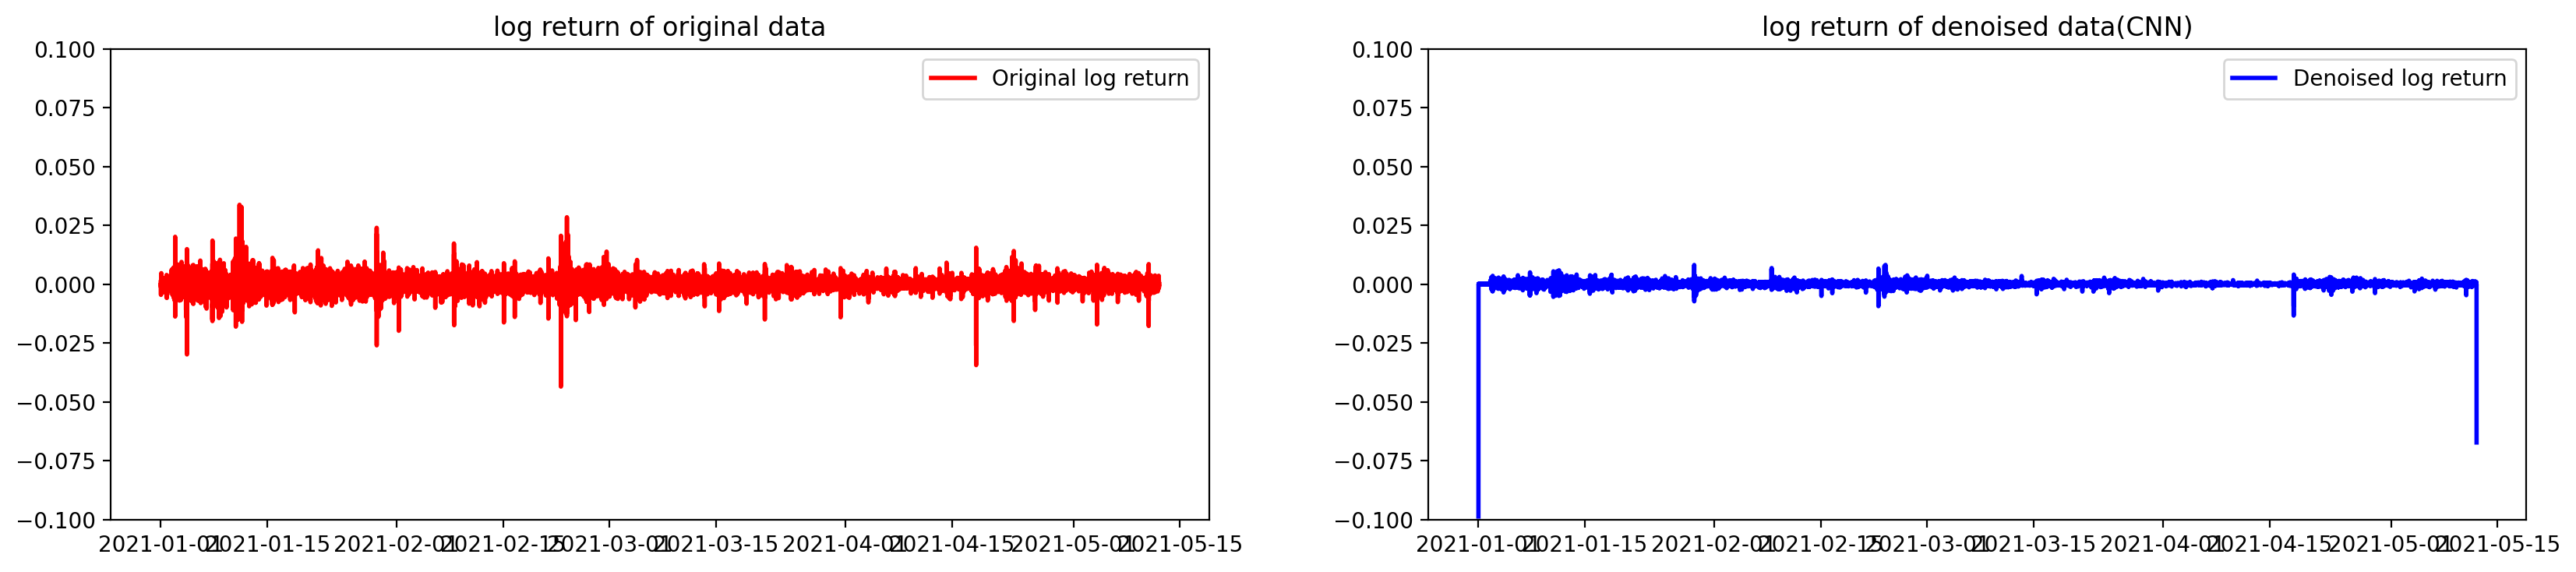

In [25]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.1,0.1)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.1,0.1)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [26]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/20):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/20):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [27]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1,percentage=1)

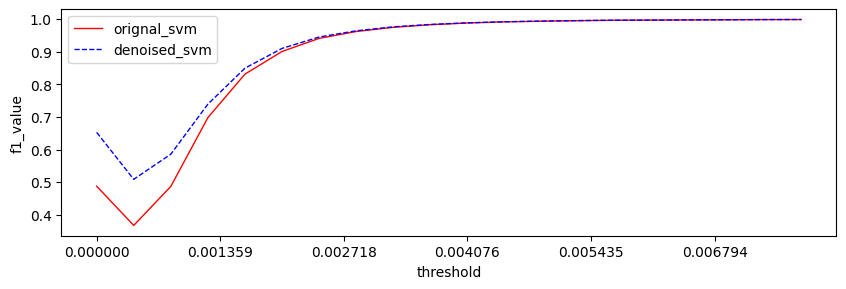

In [28]:
plt.figure(figsize=(10,3),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [29]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=10,percentage=1)

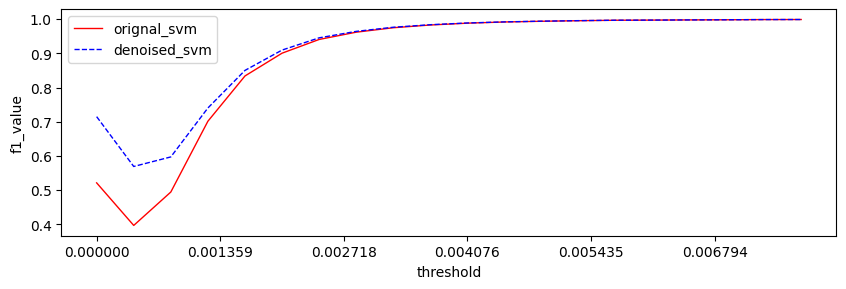

In [30]:
plt.figure(figsize=(10,3),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/20),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

# Only EMD


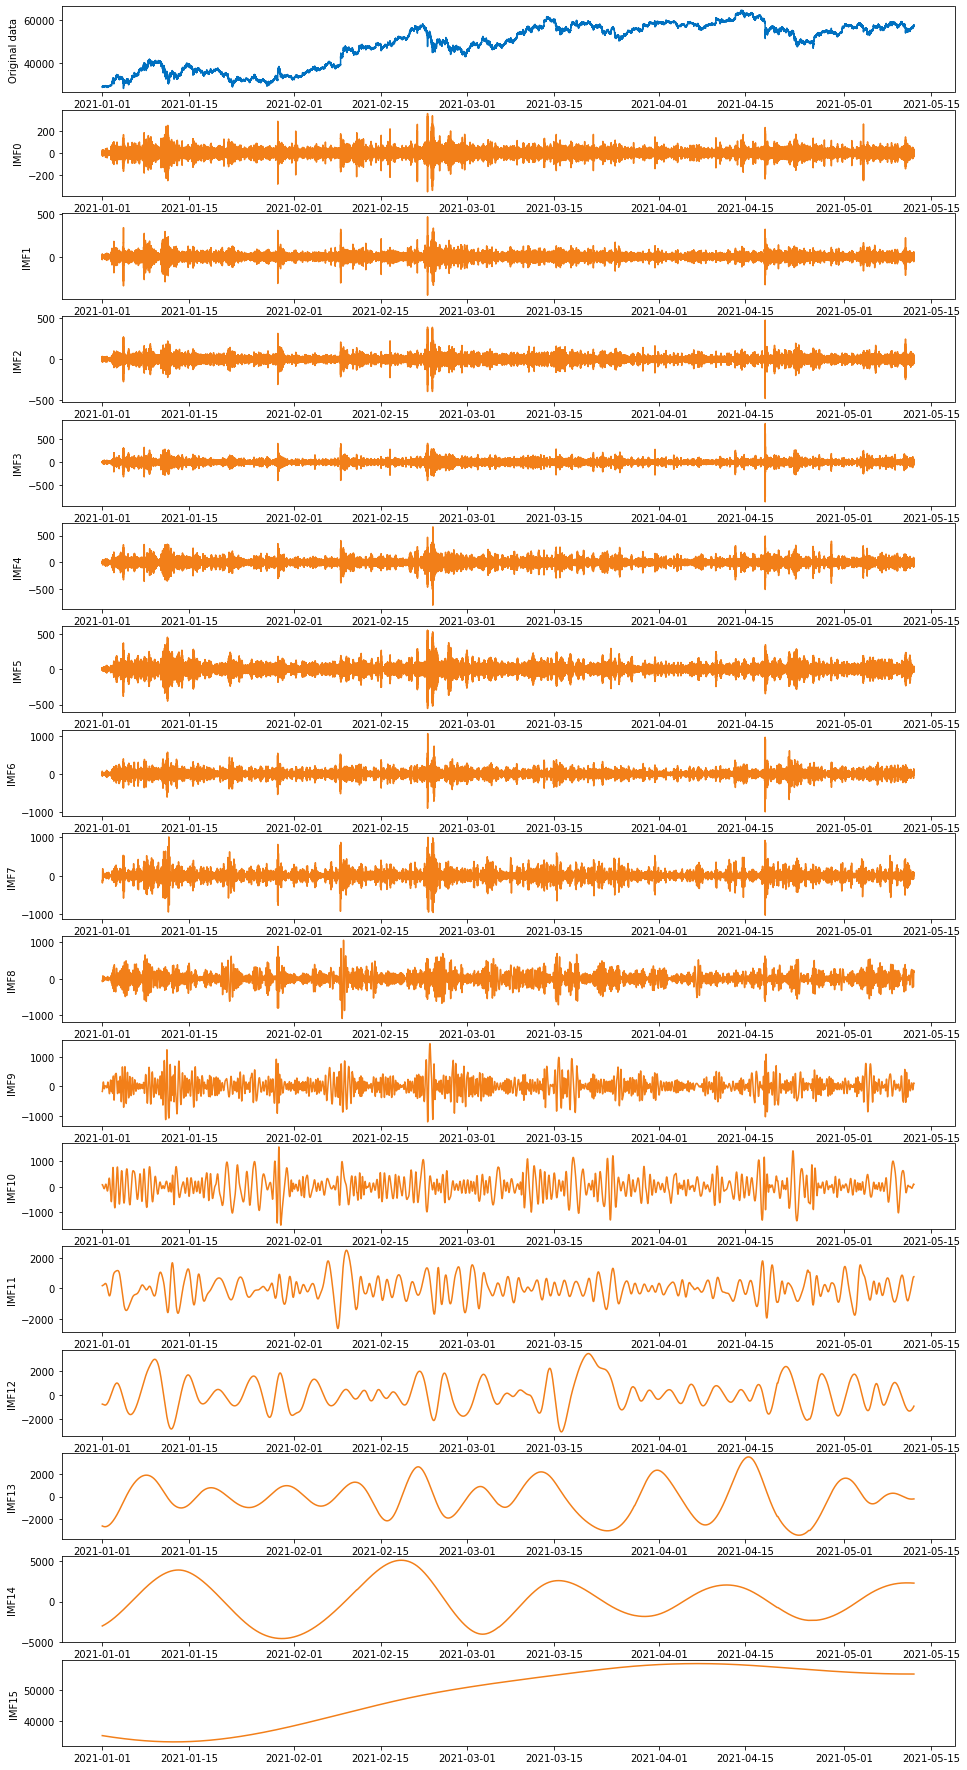

In [18]:
emdre=emd_calculate(GSPC_test)
reedm=reconstruction(emdre)

In [19]:
pure_mm_cnn=pd.DataFrame(reedm.iloc[1,:]).rename(columns={'sum1':'Adj Close'})
pure_mm_cnn

,Adj Close
Open Time,
2021-01-01 00:01:00,29011.754173
2021-01-01 00:02:00,28998.744510
2021-01-01 00:03:00,28983.301520
2021-01-01 00:04:00,28965.643884
2021-01-01 00:05:00,28947.819923
...,...
2021-05-12 05:35:00,57492.810371
2021-05-12 05:36:00,57474.040430
2021-05-12 05:37:00,57464.885043


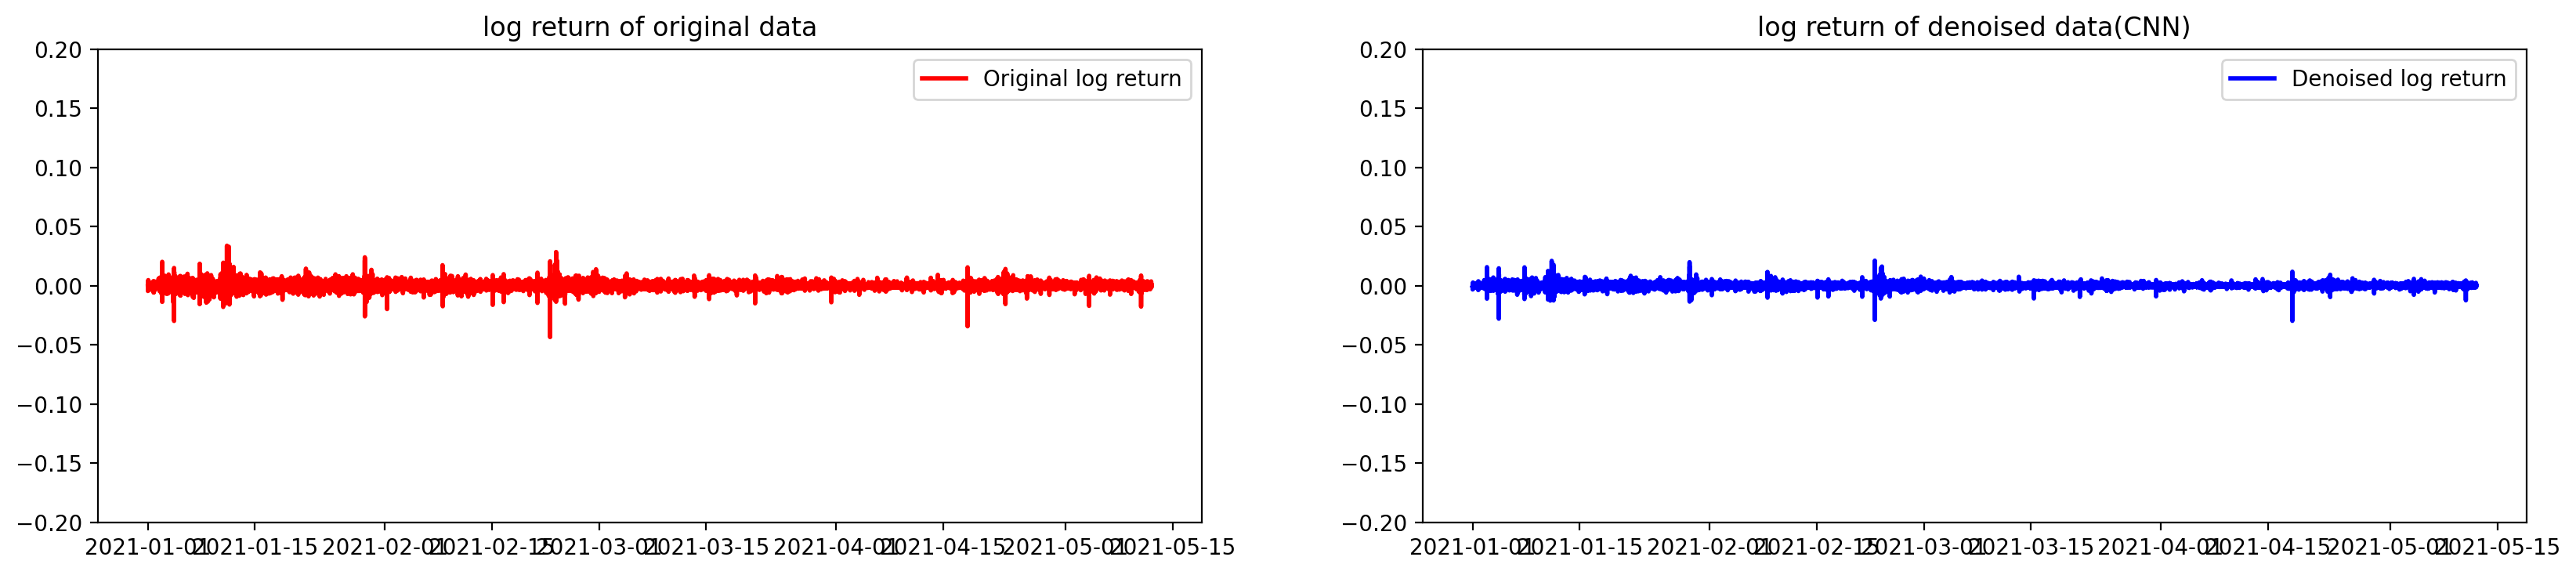

In [20]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [21]:
GSPC_test=pd.DataFrame(GSPC_test).rename(columns={'Close':'Adj Close'})

In [22]:
original=pd.DataFrame(GSPC_test['Adj Close'])
recon=pd.DataFrame(pure_mm_cnn['Adj Close'])

In [23]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [24]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

5036.898512939216
3392.601675801687
27773179.98963661
6036827.555560247
10274.759888982268
196104.92407630896
3081.3663654929774
679774.8453030193
6659.9219486224165
3176.919211401009
The last MSE: 3176.919211401009
The average MSE: 3471750.978217943


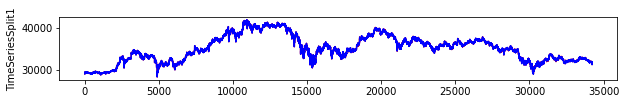

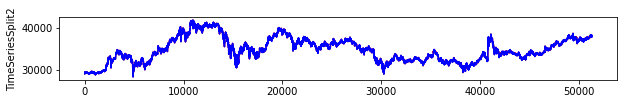

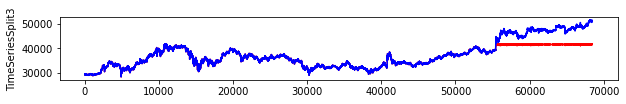

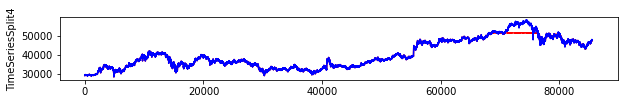

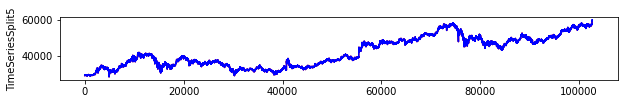

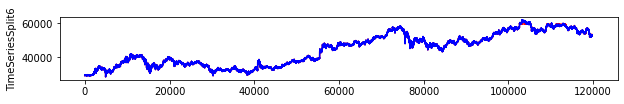

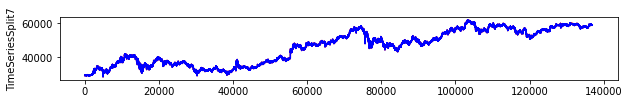

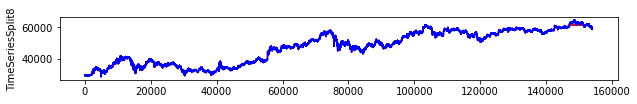

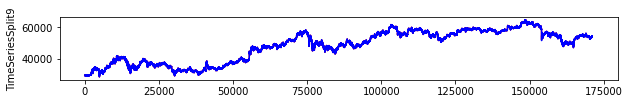

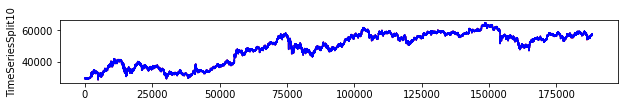

In [53]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

6959.288549566705
4641.225435585642
28271068.21184866
6095684.625164483
10902.335757344075
198253.59791907933
3662.9754652226393
717363.6937461786
8267.96235254641
4237.80436168226
The last MSE: 4237.80436168226
The average MSE: 3532104.1720600342


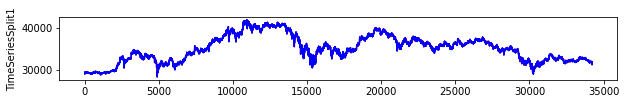

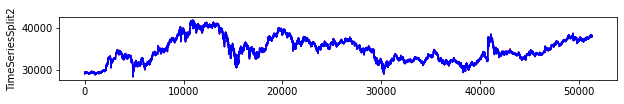

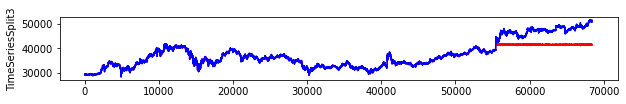

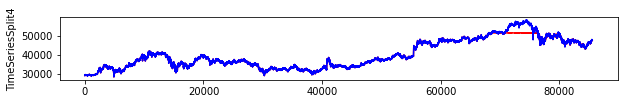

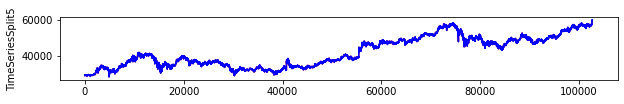

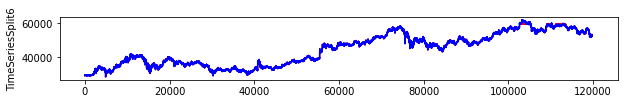

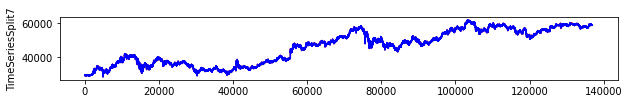

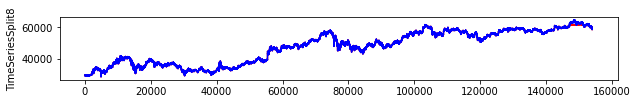

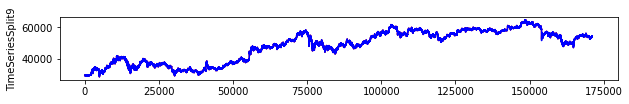

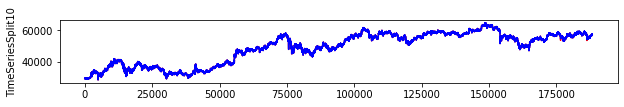

In [54]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [25]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=1):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/30):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/30):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [26]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1)

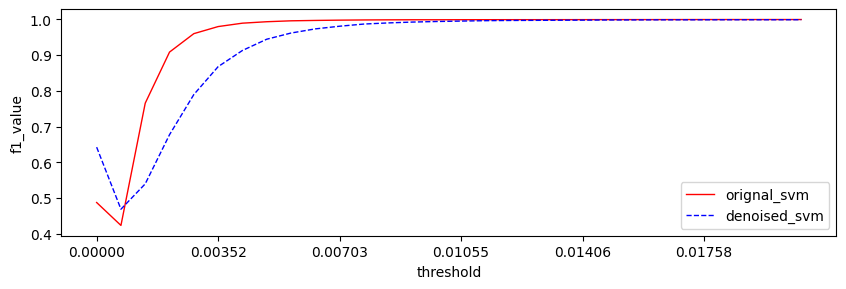

In [27]:
plt.figure(figsize=(10,3),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/30),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/30),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()